In [2]:
from essentia import *
from essentia.standard import *
from numpy import *
import matplotlib.pyplot as plt
import collections as cll
import pandas as pd

In [32]:
# Initialize algorithms

hopSize = 128
frameSize = 2048
sampleRate = 44100
guessUnvoiced = True
binResolution = 10

run_windowing = Windowing(type='hann', zeroPadding=4 * frameSize)  # Hann window with x4 zero padding
run_spectrum = Spectrum(size=frameSize * 4)
run_spectral_peaks = SpectralPeaks(minFrequency=1,
                                   maxFrequency=20000,
                                   maxPeaks=100,
                                   sampleRate=sampleRate,
                                   magnitudeThreshold=0,
                                   orderBy="frequency")
run_pitch_salience_function = PitchSalienceFunction()
run_pitch_salience_function_peaks = PitchSalienceFunctionPeaks()
run_pitch_contours = PitchContours(hopSize=hopSize)
run_pitch_contours_melody = PitchContoursMelody(guessUnvoiced=guessUnvoiced,
                                                hopSize=hopSize,
                                                binResolution=binResolution)


derivative_vector = []
pitch_vector = []
n_frames_vector = []
percentage_vector = []
time_vector = []
difference_vector = []
mean_vector = []
max_vector = []
index_max_vector = []
max_loc_vector = []

df = pd.read_csv('/home/sriram/Desktop/vibrato files/vibrato_analysis-master/Dataset/MTG-Violin/violin_vibrato.csv')
files = []

# Selecting the catagory to be anaylzed
for i in range(len(df.File_Name)):
    if df.Note[i] == 'A4':
        files.append(df.File_Name[i])

files=[files[1]]
print(files)

['Neumman-07 render 015.wav']


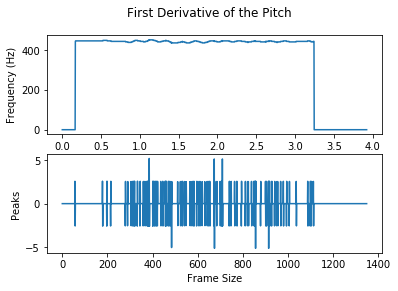

In [33]:
for file in files:
    audio = MonoLoader(filename=file)()
    audio = EqualLoudness()(audio)

    # Create a Pool
    pool = Pool();

    # 2. Cut audio into frames and compute for each frame:
    #    spectrum -> spectral peaks -> pitch salience function -> pitch salience function peaks
    
    for frame in FrameGenerator(audio, frameSize=frameSize, hopSize=hopSize):
        frame = run_windowing(frame)
        spectrum = run_spectrum(frame)
        peak_frequencies, peak_magnitudes = run_spectral_peaks(spectrum)

        salience = run_pitch_salience_function(peak_frequencies, peak_magnitudes)
        salience_peaks_bins, salience_peaks_saliences = run_pitch_salience_function_peaks(salience)

        pool.add('allframes_salience_peaks_bins', salience_peaks_bins)
        pool.add('allframes_salience_peaks_saliences', salience_peaks_saliences)

    # 3. Now, as we have gathered the required per-frame data, we can feed it to the contour
    #    tracking and melody detection algorithms:
    contours_bins, contours_saliences, contours_start_times, duration = run_pitch_contours(
        pool['allframes_salience_peaks_bins'],
        pool['allframes_salience_peaks_saliences'])
    pitch, confidence = run_pitch_contours_melody(contours_bins,
                                                  contours_saliences,
                                                  contours_start_times,
                                                  duration)
    # Eliminating the noise at the beginning and at the end
    abs_confidence = abs(confidence)
    m_common = cll.Counter(abs_confidence).most_common()[0]
    first = [index for index, val in enumerate(abs_confidence) if val == m_common[0]][0]
    last = [index for index, val in enumerate(abs_confidence) if val == m_common[0]][-1]
    pitch[0:first + 1] = 0
    pitch[last:] = 0
    pitch_vector.append(pitch)

    n_frames = len(pitch)

    time=arange(0,duration,duration/float(len(pitch)))
    time_vector.append(time)
    dr1 = derivative(pitch)
    high_derivative_indexes = [index for index, val in enumerate(dr1) if val>100]
    normalized_derivatives = [val for index, val in enumerate(dr1)
                            if index not in high_derivative_indexes]
    low_derivative_indexes = [index for index, val in enumerate(normalized_derivatives) if val<-100]
    normalized_derivatives = [val for index, val in enumerate(normalized_derivatives)
                              if index not in low_derivative_indexes]

    derivative_vector.append(normalized_derivatives)

    # Calculate the percentage of peaks od the pitch countor's derivative
    peaknumber = 0
    peaknumber = float(count_nonzero(normalized_derivatives))
    length = float(len(normalized_derivatives))
    peak_percentage = peaknumber/length*100.0
    percentage_vector.append(peak_percentage)

    # Calculates the differneces between peaks
    difference = diff(normalized_derivatives)
    difference_vector.append(difference)
    # Calculates the mean and max values of the difference array
    mean_vector.append(mean(difference))
    max_vector.append(max(difference))

    # Calculate the index of max differences to see if they appear in the end or in the beginning
    index_max = [loc for loc,val in enumerate(difference) if val == max(difference)]
    index_max_vector.append(index_max)
    for i in range(len(index_max)):
        max_loc = (index_max[i]+1)/float(len(difference))
        max_loc_vector.append(max_loc)

    plt.figure()
    plt.subplot(211)
    plt.plot(time,pitch)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('time (s)')
    plt.suptitle('Pitch')
    plt.subplot(212)
    plt.plot(range(len(difference)),difference)
    plt.ylabel('Peaks')
    plt.xlabel('Frame Size')
    plt.suptitle('First Derivative of the Pitch')

plt.show()

pass